In [1]:
# Linear regression
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

params = {'legend.fontsize': 20,
          'figure.figsize': (12, 8),
          'axes.labelsize': 20,
          'axes.titlesize': 24,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16}
mpl.rcParams.update(params)

%matplotlib inline

In [2]:
data = pd.read_csv("element_data.csv", index_col=0)
print(data)

             K       MP      BP   Z     X     r
Element                                        
Ac        29.0  1323.00  3573.0  89  1.10  1.95
Ag        88.0  1234.93  2435.0  47  1.93  1.60
Al        83.0   933.47  2792.0  13  1.61  1.25
As        40.0  1090.00   887.0  33  2.18  1.15
Au       137.0  1337.33  3129.0  79  2.54  1.35
...        ...      ...     ...  ..   ...   ...
W        304.0  3695.00  5828.0  74  2.36  1.35
Y         41.0  1799.00  3609.0  39  1.22  1.80
Yb        15.0  1097.00  1469.0  70  1.10  1.75
Zn        67.0   692.68  1180.0  30  1.65  1.35
Zr        94.0  2128.00  4682.0  40  1.33  1.55

[83 rows x 6 columns]


In [3]:
data["X^2"] = data["X"] ** 2
data["sqrt(X)"] = data["X"] ** 0.5
data["r^2"] = data["r"] ** 2
data["sqrt(r)"] = data["r"] ** 0.5
print(data)

             K       MP      BP   Z     X     r     X^2   sqrt(X)     r^2  \
Element                                                                     
Ac        29.0  1323.00  3573.0  89  1.10  1.95  1.2100  1.048809  3.8025   
Ag        88.0  1234.93  2435.0  47  1.93  1.60  3.7249  1.389244  2.5600   
Al        83.0   933.47  2792.0  13  1.61  1.25  2.5921  1.268858  1.5625   
As        40.0  1090.00   887.0  33  2.18  1.15  4.7524  1.476482  1.3225   
Au       137.0  1337.33  3129.0  79  2.54  1.35  6.4516  1.593738  1.8225   
...        ...      ...     ...  ..   ...   ...     ...       ...     ...   
W        304.0  3695.00  5828.0  74  2.36  1.35  5.5696  1.536229  1.8225   
Y         41.0  1799.00  3609.0  39  1.22  1.80  1.4884  1.104536  3.2400   
Yb        15.0  1097.00  1469.0  70  1.10  1.75  1.2100  1.048809  3.0625   
Zn        67.0   692.68  1180.0  30  1.65  1.35  2.7225  1.284523  1.8225   
Zr        94.0  2128.00  4682.0  40  1.33  1.55  1.7689  1.153256  2.4025   

In [4]:
features = [c for c in data.columns if c != "K"]
x = data[features]
y = data["K"]
# != is a comparison process, if False, then operate the following code

K = -243.8 + 4.25e-02 MP + 2.76e-02 BP + -2.48e-01 Z + 3.92e+02 X + -3.55e+02 r + -4.96e+01 X^2 + -3.85e+02 sqrt(X) + 5.40e+01 r^2 + 5.00e+02 sqrt(r)


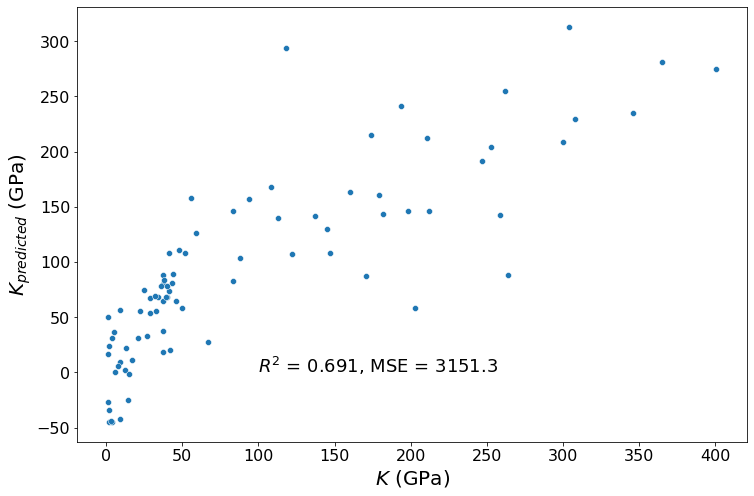

In [5]:
# Standard multiple linear regression using scikit-learn
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

reg = linear_model.LinearRegression()
reg.fit(x, y)
r2 = reg.score(x, y)
equation = ["%.2e %s" % (v, f) for v, f in zip(reg.coef_, features)]
print("K = %.1f + %s" % (reg.intercept_, " + ".join(equation)))
f, ax = plt.subplots(figsize = (12, 8))
yhat = reg.predict(data[features])
sns.scatterplot(x = y, y = yhat)
plt.ylabel(r"$K_{predicted}$ (GPa)")
plt.xlabel(r"$K$ (GPa)")
plt.annotate(r"$R^2$ = %.3f, MSE = %.1f" % (r2, mean_squared_error(y, yhat)), (100, 0), fontsize=18);

# %.2e : to second decimal & exponential
# %s : put the string in
# %.1f : intercept to 1st decimal

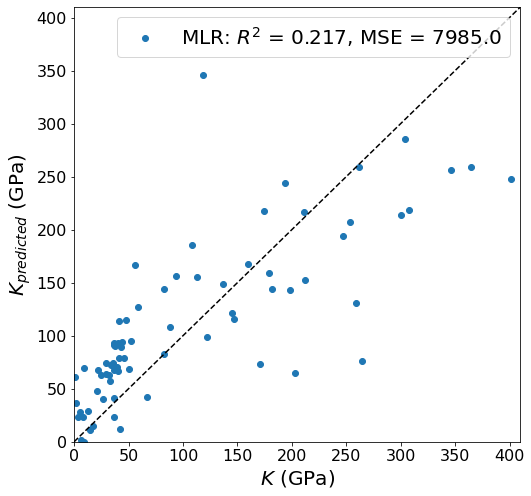

In [6]:
# five-fold cross-validation
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import r2_score

kfold = KFold(n_splits = 5, shuffle = True, random_state = 42)

mlr = linear_model.LinearRegression()
yhat_mlr = cross_val_predict(mlr, x, y, cv = kfold)
r2_mlr = r2_score(y, yhat_mlr)
mse_mlr = mean_squared_error(y, yhat_mlr)
label_mlr = "MLR: $R^2$ = %.3f, MSE = %.1f" %(r2_mlr, mse_mlr)

f, ax = plt.subplots(figsize = (8, 8))
plt.plot(y, yhat_mlr, 'o', label = label_mlr)
plt.ylabel(r"$K_{predicted}$ (GPa)")
plt.xlabel(r"$K$ (GPa)")
plt.legend()
plt.xlim([0, 410])
plt.ylim([0, 410])
plt.plot([0, 410], [0, 410], 'k--')

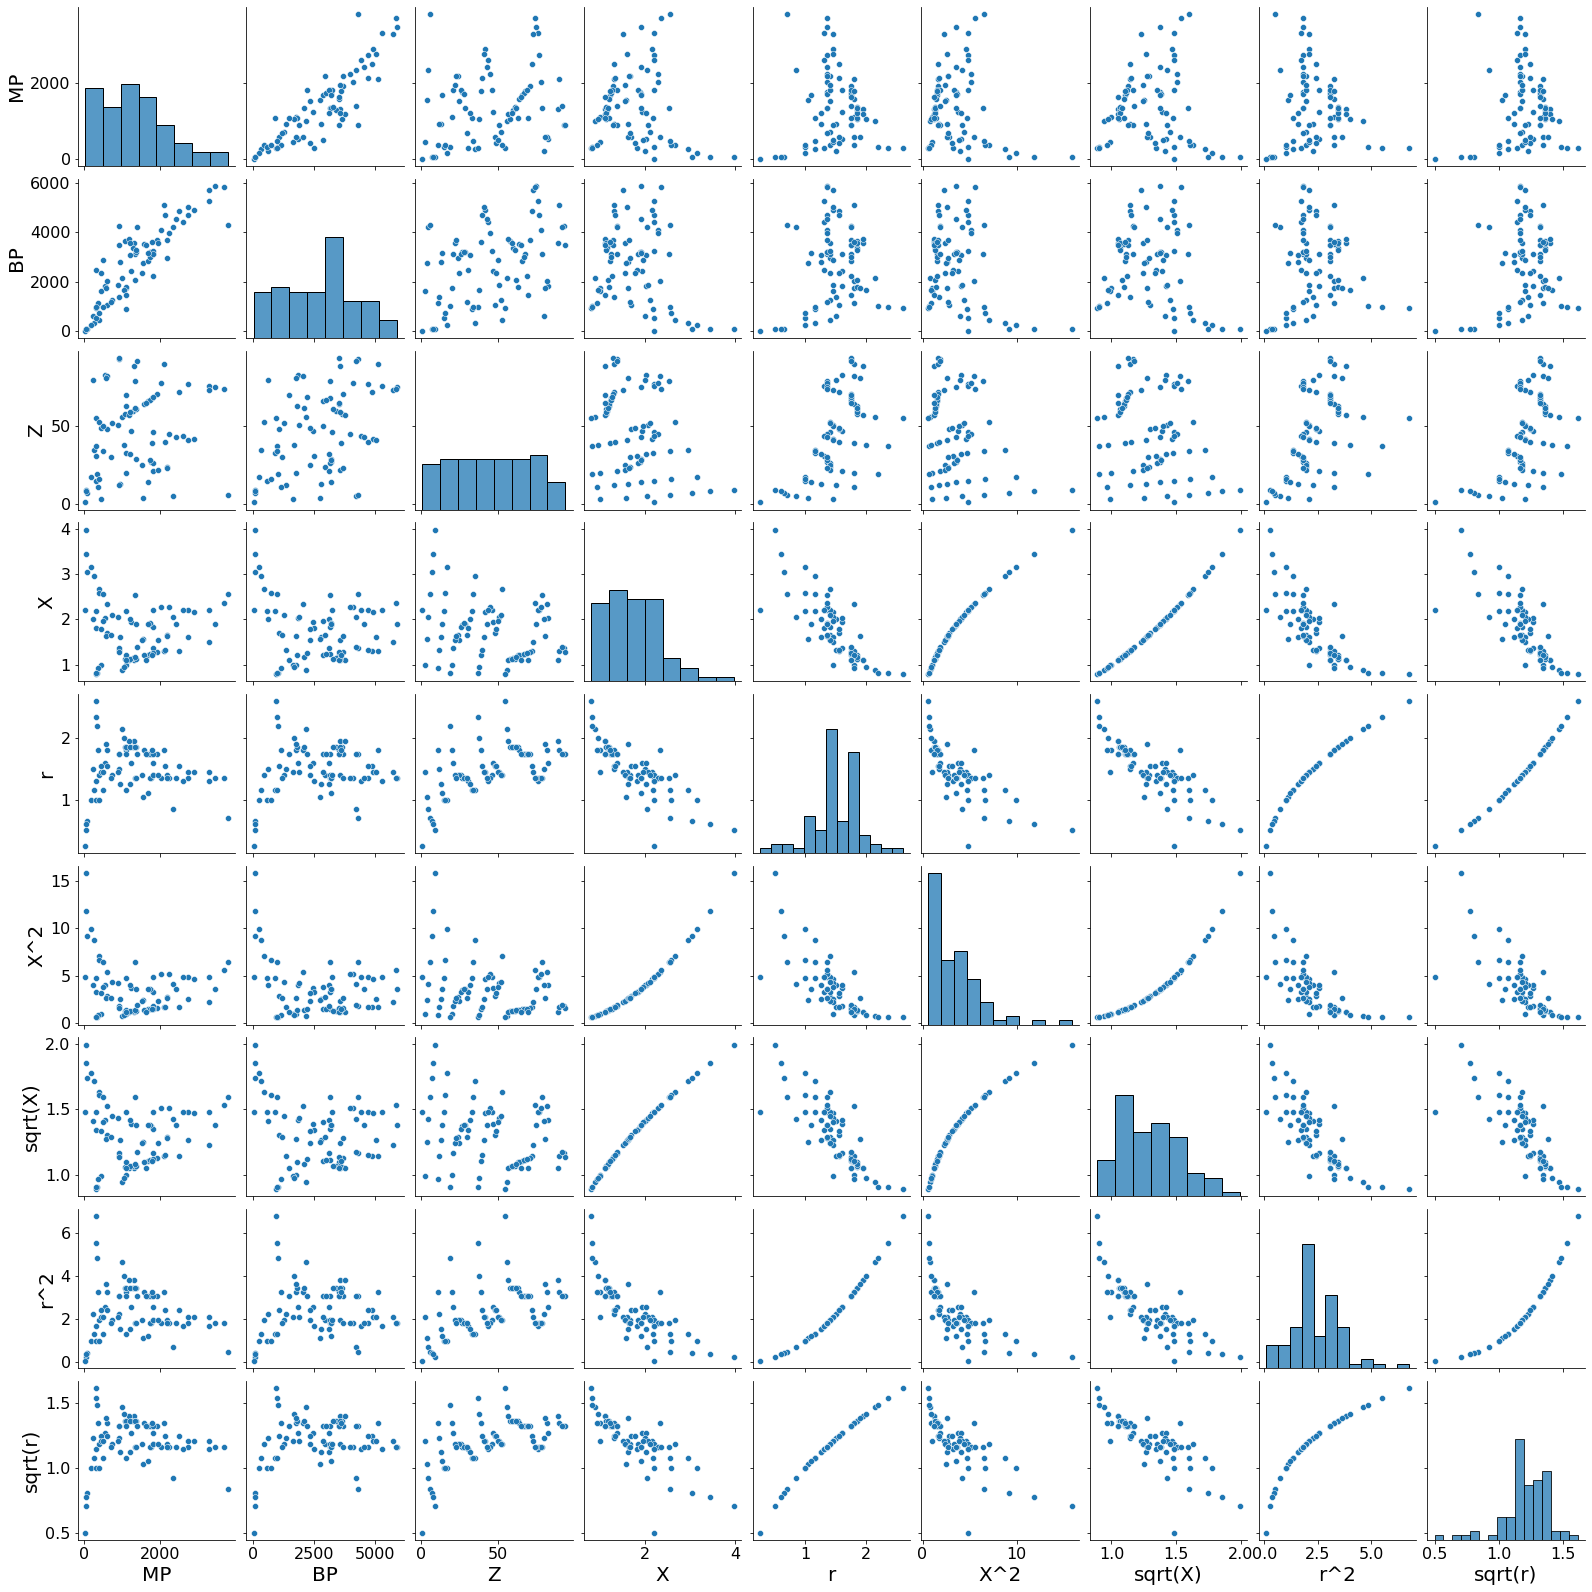

In [7]:
# Correlations between features
grid = sns.pairplot(data[features])

In [8]:
# MP and BP are correlated with each other 
# And X is inversely related to r in some way 
# Obviously, X and X^2 are correlated

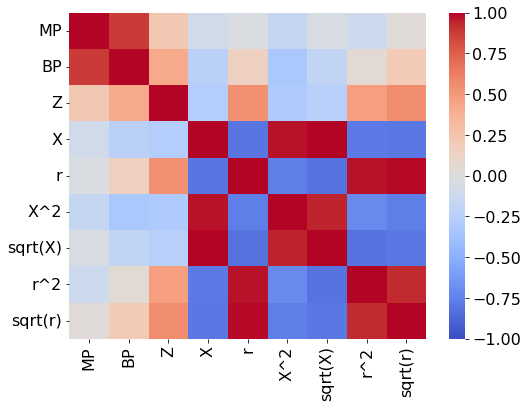

In [9]:
f, ax = plt.subplots(figsize = (8, 6))
sns.heatmap(x.corr(), cmap = "coolwarm", vmin = -1, vmax = 1, ax = ax);
# correlation plot

In [10]:
# Subset selection
from sklearn.feature_selection import SelectKBest, f_regression

def identify_columns(x_new, nrows = 10):
    columns = x.columns
    xvalues = x.values
    dist = np.linalg.norm(xvalues[:nrows, :, None] - x_new[:nrows, None, :], axis = 0)
    return columns[np.argmin(dist, axis = 0)].values

sel = SelectKBest(f_regression, k = 3)
x_new = sel.fit_transform(x, y)
print(f"Selected features {identify_columns(x_new)}")

Selected features ['MP' 'BP' 'r^2']


In [11]:
s = ', '.join(['%s: %3e' % (i, j) for i, j in zip(x.columns, sel.pvalues_)])
print("The p values for the variables are " + s)

The p values for the variables are MP: 5.016947e-17, BP: 3.285061e-14, Z: 1.382246e-01, X: 1.760384e-01, r: 9.118056e-02, X^2: 6.984657e-01, sqrt(X): 6.706273e-02, r^2: 1.346068e-02, sqrt(r): 2.524374e-01


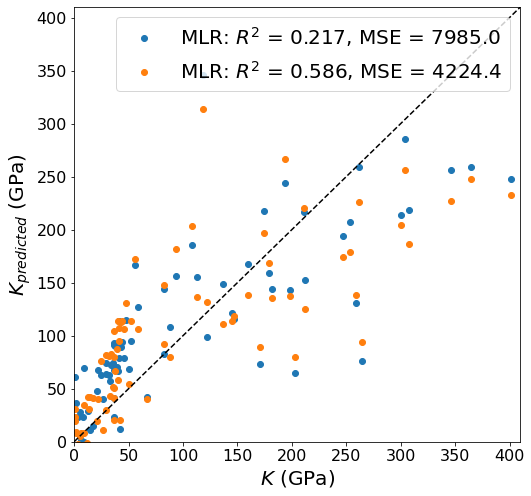

In [12]:
mlr_best = linear_model.LinearRegression()
yhat_mlr_best = cross_val_predict(mlr_best, x_new, y, cv = kfold)
r2_mlr_best = r2_score(y, yhat_mlr_best)
mse_mlr_best = mean_squared_error(y, yhat_mlr_best)
label_mlr_best = "MLR: $R^2$ = %.3f, MSE = %.1f" % (r2_mlr_best, mse_mlr_best)

f, ax = plt.subplots(figsize = (8, 8))
plt.plot(y, yhat_mlr, 'o', label = label_mlr)
plt.plot(y, yhat_mlr_best, 'o', label = label_mlr_best)
l = plt.ylabel(r"$K_{predicted}$ (GPa)")
l = plt.xlabel(r"$K$ (GPa)")
plt.legend()
plt.xlim([0, 410])
plt.ylim([0, 410])
plt.plot([0, 410], [0, 410], 'k--')

In [13]:
# Shrinkage
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x)
means_ = scaler.mean_
stds = scaler.scale_
z = scaler.transform(x)
print(x)
print(z)

              MP      BP   Z     X     r     X^2   sqrt(X)     r^2   sqrt(r)
Element                                                                     
Ac       1323.00  3573.0  89  1.10  1.95  1.2100  1.048809  3.8025  1.396424
Ag       1234.93  2435.0  47  1.93  1.60  3.7249  1.389244  2.5600  1.264911
Al        933.47  2792.0  13  1.61  1.25  2.5921  1.268858  1.5625  1.118034
As       1090.00   887.0  33  2.18  1.15  4.7524  1.476482  1.3225  1.072381
Au       1337.33  3129.0  79  2.54  1.35  6.4516  1.593738  1.8225  1.161895
...          ...     ...  ..   ...   ...     ...       ...     ...       ...
W        3695.00  5828.0  74  2.36  1.35  5.5696  1.536229  1.8225  1.161895
Y        1799.00  3609.0  39  1.22  1.80  1.4884  1.104536  3.2400  1.341641
Yb       1097.00  1469.0  70  1.10  1.75  1.2100  1.048809  3.0625  1.322876
Zn        692.68  1180.0  30  1.65  1.35  2.7225  1.284523  1.8225  1.161895
Zr       2128.00  4682.0  40  1.33  1.55  1.7689  1.153256  2.4025  1.244990

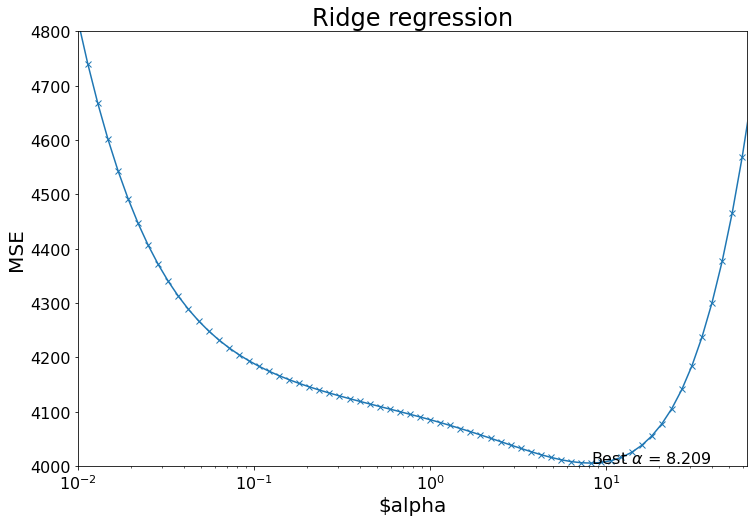

In [14]:
# Ridge regression
from sklearn.model_selection import cross_validate, KFold

cv_results = []
coeffs = []
alphas = np.logspace(-2, 2, 71)
kfold = KFold(n_splits = 10, shuffle = True, random_state = 42)

for alpha in alphas:
    ridge = linear_model.Ridge(alpha = alpha, max_iter = 10000)
    ridge.fit(z, y)
    scores = cross_validate(ridge, z, y, cv = kfold, scoring = "neg_mean_squared_error")
    cv_results.append([alpha, -np.mean(scores["test_score"])] + list(ridge.coef_))
    
cv_results = pd.DataFrame(cv_results, columns = ["alpha", "score"] + features)
f, ax = plt.subplots(figsize = (12, 8))
plt.plot(cv_results["alpha"], cv_results["score"], '-x')
plt.xlim([1e-2, 10**1.8])
plt.ylim((4000, 4800))
plt.xscale(r'log')
plt.xlabel(r'$alpha')
plt.ylabel(r'MSE')
plt.title(r'Ridge regression')
best_alpha = cv_results["alpha"][cv_results["score"].idxmin()]
plt.annotate(r"Best $\alpha$ = %.3f" % best_alpha, (best_alpha, cv_results["score"].min()), fontsize=16);

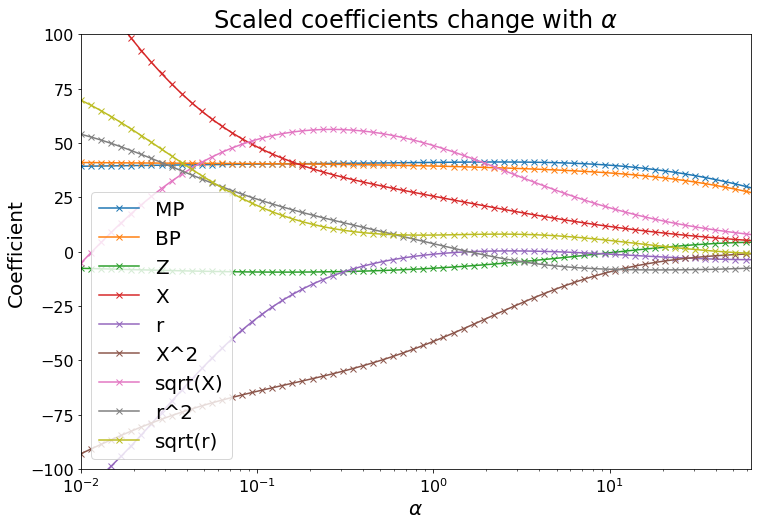

In [15]:
f, ax = plt.subplots(figsize=(12, 8))
for f in features:
    plt.plot(cv_results["alpha"], cv_results[f], '-x', label=f)
    plt.xscale('log')
    plt.xlabel(r'$\alpha$')
    plt.ylabel('Coefficient')
    plt.title(r'Scaled coefficients change with $\alpha$')
plt.legend()
plt.xlim([1e-2, 10**1.8])
plt.ylim([-100, 100]);

In [16]:
reg = linear_model.Ridge(alpha = best_alpha, max_iter = 10000)
reg.fit(z, y) 

real_coef = reg.coef_  / stds      # convert back to unnormalized inputs
real_interp = reg.intercept_ - means_.dot(real_coef)  # convert back to unnormalized inputs

equation = ["%.2e %s" % (v, f) for v, f in zip(real_coef, features)]
print("K = %.1f + %s" % (real_interp, " + ".join(equation)))

K = -196.3 + 4.44e-02 MP + 2.43e-02 BP + -4.78e-02 Z + 1.98e+01 X + -2.00e+00 r + -4.27e+00 X^2 + 9.56e+01 sqrt(X) + -6.84e+00 r^2 + 3.33e+01 sqrt(r)


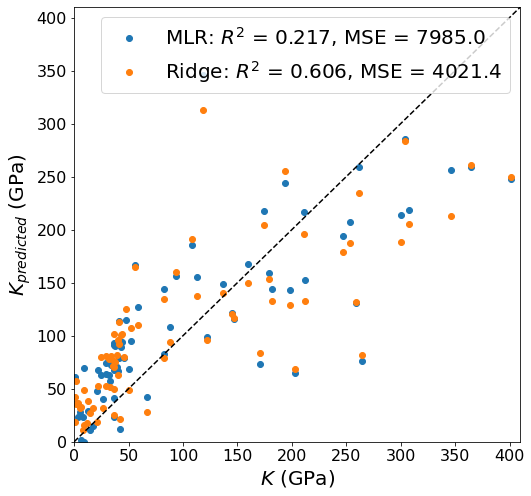

In [17]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score

ridge = linear_model.Ridge(alpha = best_alpha, max_iter = 10000)
yhat_ridge = cross_val_predict(ridge, z, y, cv = kfold)
r2_ridge = r2_score(y, yhat_ridge)
mse_ridge = mean_squared_error(y, yhat_ridge)
label_ridge = "Ridge: $R^2$ = %.3f, MSE = %.1f" % (r2_ridge, mse_ridge)

f, ax = plt.subplots(figsize = (8, 8))
plt.plot(y, yhat_mlr, 'o', label = label_mlr)
plt.plot(y, yhat_ridge, 'o', label = label_ridge)
l = plt.ylabel("$K_{predicted}$ (GPa)")
l = plt.xlabel("$K$ (GPa)")
plt.legend()
plt.xlim([0, 410])
plt.ylim([0, 410])
plt.plot([0, 410], [0, 410], 'k--')

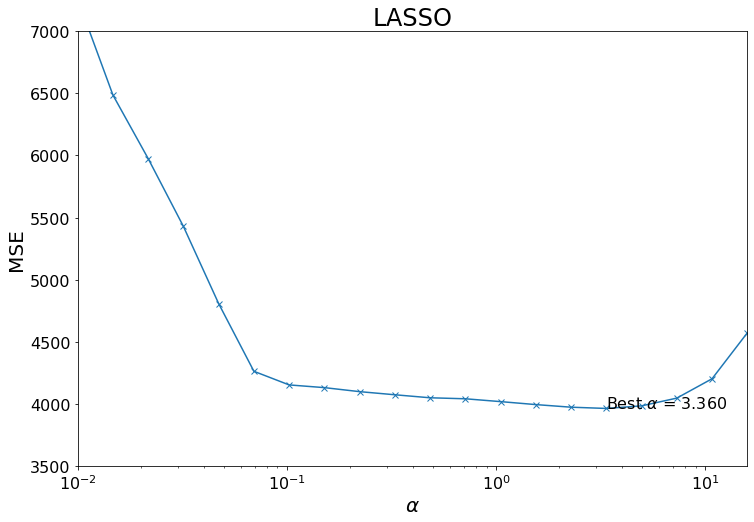

In [18]:
# LASSO
alphas = np.logspace(-2, 1.2, 20)
cv_results = []
coeffs = []
for alpha in alphas:
    lasso = linear_model.Lasso(alpha = alpha, max_iter = 100000)
    lasso.fit(z, y)
    scores = cross_validate(lasso, z, y, cv = kfold, scoring = 'neg_mean_squared_error')
    cv_results.append([alpha, -np.mean(scores["test_score"])] + list(lasso.coef_))
    
cv_results = pd.DataFrame(cv_results, columns = ["alpha", 'score'] + features)
f, ax = plt.subplots(figsize = (12, 8))
plt.plot(cv_results["alpha"], cv_results["score"], '-x')
plt.xlim([1e-2, 10**1.2])
plt.ylim((3500, 7000))
plt.xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel('MSE')
plt.title('LASSO')
best_alpha = cv_results["alpha"][cv_results["score"].idxmin()]
plt.annotate(r"Best $\alpha$ = %.3f" % best_alpha, (best_alpha, cv_results["score"].min()), fontsize = 16);

(0.01, 15.848931924611133)

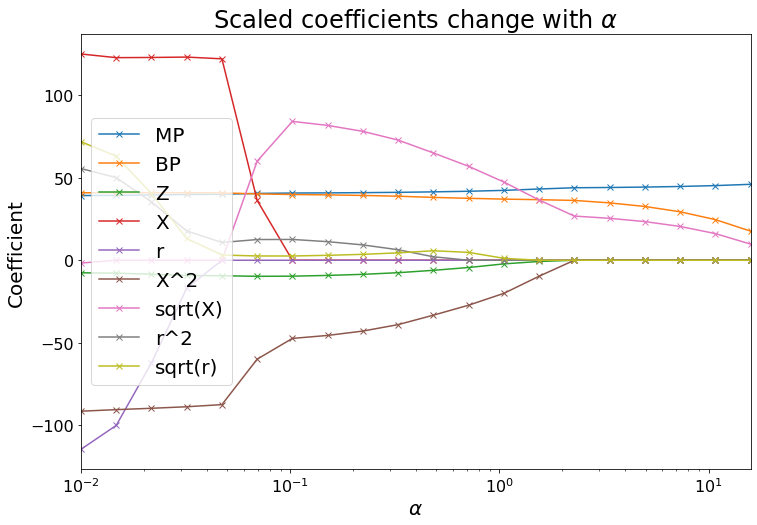

In [19]:
f, ax = plt.subplots(figsize = (12, 8))
for f in features:
    plt.plot(cv_results["alpha"], cv_results[f], '-x', label = f)
    plt.xscale('log')
    plt.xlabel(r'$\alpha$')
    plt.ylabel('Coefficient')
    plt.title(r'Scaled coefficients change with $\alpha$')
plt.legend()
plt.xlim([1e-2, 10**1.2])

In [20]:
reg = linear_model.Lasso(alpha = best_alpha, max_iter = 10000)
reg.fit(z, y)

real_coef = reg.coef_ / stds  # convert back to unnormalized inputs
real_interp = reg.intercept_ - means_.dot(real_coef)  # convert back to unnormalized inputs

equation = ["%.2e %s" % (v, f) for v, f in zip(real_coef, features) if abs(v) > 1e-4]
print("K = %.1f + %s" % (real_interp, " + ".join(equation)))

K = -178.1 + 4.87e-02 MP + 2.31e-02 BP + 1.09e+02 sqrt(X)


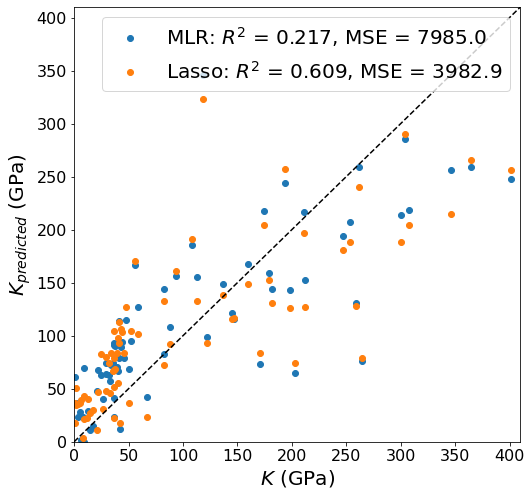

In [21]:
lasso = linear_model.Lasso(alpha=best_alpha, max_iter=10000)
yhat_lasso = cross_val_predict(lasso, z, y, cv=kfold)
r2_lasso = r2_score(y, yhat_lasso)
mse_lasso = mean_squared_error(y, yhat_lasso)
label_lasso = "Lasso: $R^2$ = %.3f, MSE = %.1f" % (r2_lasso, mse_lasso)

f, ax = plt.subplots(figsize=(8, 8))
plt.plot(y, yhat_mlr, 'o', label=label_mlr)
plt.plot(y, yhat_lasso, 'o', label=label_lasso)
l = plt.ylabel("$K_{predicted}$ (GPa)")
l = plt.xlabel("$K$ (GPa)")
plt.legend()
plt.xlim([0, 410])
plt.ylim([0, 410])
plt.plot([0, 410], [0, 410], 'k--');

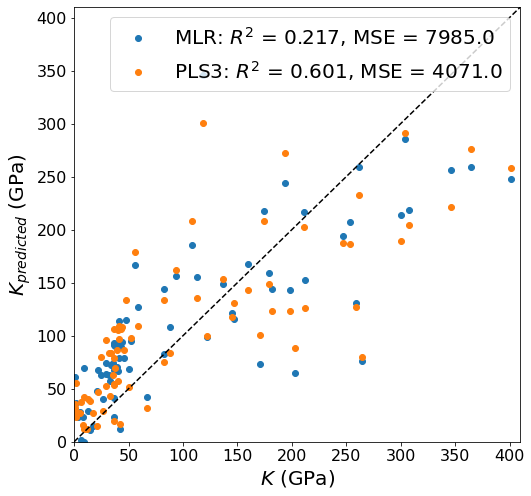

In [22]:
# Partial Least Squares
from sklearn.cross_decomposition import PLSRegression
cv_results = []
coeffs = []
pls = PLSRegression(n_components = 2)
pls.fit(x, y)
yhat_pls = cross_val_predict(pls, x, y, cv = kfold)
r2_pls = r2_score(y, yhat_pls)
mse_pls = mean_squared_error(y, yhat_pls)
label_pls = "PLS3: $R^2$ = %.3f, MSE = %.1f" % (r2_pls, mse_pls)

f, ax = plt.subplots(figsize = (8, 8))
plt.plot(y, yhat_mlr, 'o', label = label_mlr)
plt.plot(y, yhat_pls, 'o', label = label_pls)
l = plt.ylabel("$K_{predicted}$ (GPa)")
l = plt.xlabel("$K$ (GPa)")
plt.legend()
plt.xlim([0, 410])
plt.ylim([0, 410])
plt.plot([0, 410], [0, 410], 'k--');